In [2]:
!pip install tensorflow==2.0.0rc0 &> log
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 450kB 43.8MB/s 
     |████████████████████████████████| 3.9MB 53.2MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-03-16 18:18:34--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.249.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.249.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  42.2MB/s    in 30s     

2020-03-16 18:19:04 (50.3 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("init_kernel", 1)
  config.add_hparam("init_stride", 1)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 3)
  config.add_hparam("n_res", [3, 3, 3])
  config.add_hparam("filters", [32, 32, 32])
  config.add_hparam("strides", [1, 1, 1])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("init_max_pool", False)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("with_dense", False)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 2e-4)
  
  return config

In [10]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## Check invertibility

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

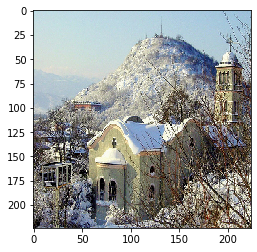

In [12]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

In [13]:
np.max(abs(res_x - x0[0]))

0.00035429

## Learning

In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 2.2191312313079834
Training acc over epoch: 0.11109937727451324

Val loss over epoch: 2.2267284393310547
Val acc over epoch: 0.16713376343250275

Epoch: 2
Training loss over epoch: 2.1245017051696777
Training acc over epoch: 0.21649593114852905

Val loss over epoch: 2.1451826095581055
Val acc over epoch: 0.222675159573555

Epoch: 3
Training loss over epoch: 2.0997281074523926
Training acc over epoch: 0.24025768041610718

Val loss over epoch: 2.1865272521972656
Val acc over epoch: 0.18853503465652466

Epoch: 4
Training loss over epoch: 2.079348087310791
Training acc over epoch: 0.25166332721710205

Val loss over epoch: 2.1245274543762207
Val acc over epoch: 0.2321019172668457

Epoch: 5
Training loss over epoch: 2.0615642070770264
Training acc over epoch: 0.26496991515159607

Val loss over epoch: 2.1356005668640137
Val acc over epoch: 0.21503184735774994

Epoch: 6
Training loss over epoch: 2.04474139213562
Training acc over epoch: 0.2635970115661621

Va

In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 1.7196656465530396
Training acc over epoch: 0.42042455077171326

Val loss over epoch: 2.1429972648620605
Val acc over epoch: 0.25783440470695496

Epoch: 2
Training loss over epoch: 1.6929105520248413
Training acc over epoch: 0.43774423003196716

Val loss over epoch: 2.149707317352295
Val acc over epoch: 0.25707006454467773

Epoch: 3
Training loss over epoch: 1.6773629188537598
Training acc over epoch: 0.4434470236301422

Val loss over epoch: 2.1552250385284424
Val acc over epoch: 0.2647133767604828

Epoch: 4
Training loss over epoch: 1.6716859340667725
Training acc over epoch: 0.4471433162689209

Val loss over epoch: 2.169184684753418
Val acc over epoch: 0.2555414140224457

Epoch: 5
Training loss over epoch: 1.6621949672698975
Training acc over epoch: 0.4469321072101593

Val loss over epoch: 2.162449359893799
Val acc over epoch: 0.2588534951210022

Epoch: 6
Training loss over epoch: 1.6530643701553345
Training acc over epoch: 0.45316293835639954

Val 

In [0]:
model.load_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")

### Атака

In [15]:
test = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))

Found 3925 images belonging to 10 classes.


Real class:  5
Predicted class:  2


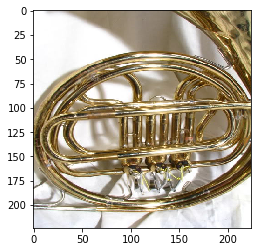

Real class:  1
Predicted class:  2


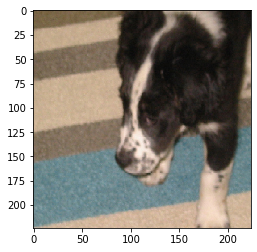

Metameric image


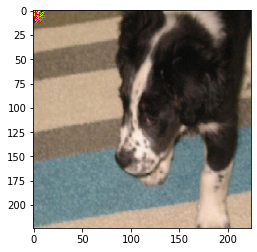

In [19]:
x, y = test.next()

x0 = tf.reshape(x[0], (1, *config.input_shape))
logits, _ = model(x0, training=False)
print("Real class: ", int(y[0]))
print("Predicted class: ", np.argmax(logits))
plt.imshow(x0[0])
plt.show()

x1 = tf.reshape(x[1], (1, *config.input_shape))
nuisance = model.get_nuisance(x1)
logits_x1, _ = model(x1, training=False)
print("Real class: ", int(y[1]))
print("Predicted class: ", np.argmax(logits_x1))
plt.imshow(x1[0])
plt.show()

print("Metameric image")
new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)
plt.show()

Real class:  7
Predicted class:  2


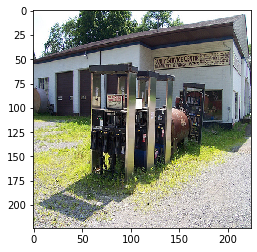

Real class:  4
Predicted class:  4


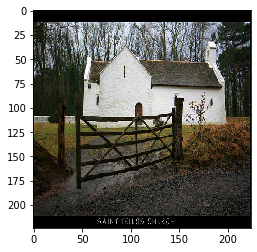

Metameric image


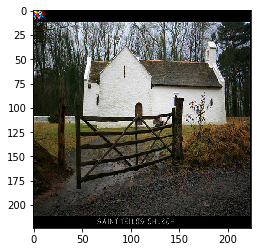

In [20]:
x, y = test.next()

x0 = tf.reshape(x[0], (1, *config.input_shape))
logits, _ = model(x0, training=False)
print("Real class: ", int(y[0]))
print("Predicted class: ", np.argmax(logits))
plt.imshow(x0[0])
plt.show()

x1 = tf.reshape(x[1], (1, *config.input_shape))
nuisance = model.get_nuisance(x1)
logits_x1, _ = model(x1, training=False)
print("Real class: ", int(y[1]))
print("Predicted class: ", np.argmax(logits_x1))
plt.imshow(x1[0])
plt.show()

print("Metameric image")
new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)
plt.show()